In [0]:
# Install tensorflow 2.x in Colab

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
  
# Import libraries  
from __future__ import absolute_import, division, print_function, unicode_literals

#Power data classification/regression with CNN
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import time as time
import matplotlib.pyplot as plt
import pydot
import csv as csv
%matplotlib inline
print("TensorFlow version:",tf.__version__)

TensorFlow 2.x selected.
TensorFlow version: 2.0.0


In [0]:
!wget https://raw.githubusercontent.com/alexferreiram/CNN-on-Wind-Power-Data/master/MISO_power_data_classification_labels.csv
!wget https://raw.githubusercontent.com/alexferreiram/CNN-on-Wind-Power-Data/master/MISO_power_data_input.csv
  
#Read total rows in csv file without loading into memory
def data_set_size(csv_file):
    with open(csv_file) as csvfile:
        csv_rows = 0
        for _ in csvfile:
            csv_rows += 1
    print("Numer of rows in csv:",csv_rows)
    return csv_rows-1            #Remove header from count and return

csv_file = "./MISO_power_data_classification_labels.csv"
n_train = data_set_size(csv_file)
print("Training data set size:",n_train)

--2019-10-16 21:19:27--  https://raw.githubusercontent.com/alexferreiram/CNN-on-Wind-Power-Data/master/MISO_power_data_classification_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119285 (116K) [text/plain]
Saving to: ‘MISO_power_data_classification_labels.csv’

MISO_power_data_cla 100%[===================>] 116.49K  --.-KB/s    in 0.02s   

2019-10-16 21:19:33 (5.23 MB/s) - ‘MISO_power_data_classification_labels.csv’ saved [119285/119285]

--2019-10-16 21:19:34--  https://raw.githubusercontent.com/alexferreiram/CNN-on-Wind-Power-Data/master/MISO_power_data_input.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)

In [0]:
#Python generator to supply batches of traning data during training with loading full data set to memory
def power_data_generator(batch_size=10,gen_type='training'):
    valid_size = max(1,np.int(0.2*batch_size))
    #print(valid_size)
    while 1:
        df_input=pd.read_csv('./MISO_power_data_input.csv',usecols =['Wind_MWh','Actual_Load_MWh'],chunksize =24*(batch_size+valid_size), iterator=True)
        df_target=pd.read_csv('./MISO_power_data_classification_labels.csv',usecols =['LowPower','MedPower','HighPower','LowVar','MedVar','HighVar','LowWind','HighWind'],chunksize =batch_size+valid_size, iterator=True)
  
        for chunk, chunk2 in  zip(df_input,df_target):
            InputX = chunk.values
            InputX = np.resize(InputX,(batch_size+valid_size,24,2,1))
            InputX.astype('float32', copy=False)
            InputY = chunk2.values
            InputY = np.resize(InputY,(batch_size+valid_size,8))
            InputY.astype('float32', copy=False)
            if gen_type =='training':
                yield (InputX[0:batch_size],InputY[0:batch_size])
            elif gen_type =='validation':
                yield (InputX[batch_size:batch_size+valid_size],InputY[batch_size:batch_size+valid_size])
                #yield (InputX,InputY)
            elif gen_type =='inference':
                yield InputX

In [0]:
train_generator= power_data_generator(batch_size=2,gen_type='training')
valid_generator= power_data_generator(batch_size=2,gen_type='validation')
#next(train_generator)

In [0]:
#Define model using Keras
Yclasses = 8 #Number of output classes

#bias0 = tf.contrib.keras.initializers.glorot_uniform()
#bias0 = tf.contrib.keras.initializers.RandomUniform() 
bias0 =  'zeros'
#datagen= tf.contrib.keras.preprocessing.image.ImageDataGImageDataGenerator()
max_power = 100000.0  #For normalizing


model = keras.Sequential([
    tf.keras.layers.Input(shape=(24,2,1),name='InputLayer'),                    
    tf.keras.layers.Lambda(lambda x:x/max_power,name='Normalizing'),
    tf.keras.layers.Conv2D(filters=4,kernel_size=(6,2),strides=(1,1),activation='relu',bias_initializer=bias0,name='ConvLayer1'),
    tf.keras.layers.Conv2D(filters=4,kernel_size=(6,1),strides=(1,1),activation='relu',bias_initializer=bias0,name='ConvLayer2'),
    tf.keras.layers.Conv2D(filters=4,kernel_size=(5,1),strides=(1,1),activation='relu',bias_initializer=bias0,name='ConvLayer3'),
    tf.keras.layers.Flatten(name="Flatten"),
    tf.keras.layers.Dense(units = 8,activation='relu',bias_initializer=bias0,name='FeedForward1'),
    tf.keras.layers.Dense(units = 8,activation='relu',bias_initializer=bias0,name='FeedForward2'),
    tf.keras.layers.Dense(units = Yclasses,activation='sigmoid',bias_initializer=bias0,name='OutputLayer'),
])

model.compile(loss='binary_crossentropy',optimizer='adam',verbose = 2,metrics=['binary_accuracy'])
model.summary()

log_folder ="./log/"  
summary = tf.keras.callbacks.TensorBoard(log_dir=log_folder,histogram_freq =1,write_graph=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalizing (Lambda)         (None, 24, 2, 1)          0         
_________________________________________________________________
ConvLayer1 (Conv2D)          (None, 19, 1, 4)          52        
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 14, 1, 4)          100       
_________________________________________________________________
ConvLayer3 (Conv2D)          (None, 10, 1, 4)          84        
_________________________________________________________________
Flatten (Flatten)            (None, 40)                0         
_________________________________________________________________
FeedForward1 (Dense)         (None, 8)                 328       
_________________________________________________________________
FeedForward2 (Dense)         (None, 8)                 7

In [0]:
#tf.contrib.keras.utils.plot_model(model=model)
samples_per_batch = 5
train_generator= power_data_generator(batch_size=samples_per_batch,gen_type='training')
valid_generator= power_data_generator(batch_size=samples_per_batch,gen_type='validation')
number_of_batches = np.int32(n_train/(samples_per_batch+max(1,np.int32(0.2*samples_per_batch)))) 
#Training starts
t = time.time()
history = model.fit(train_generator, steps_per_epoch= number_of_batches,epochs=10,validation_data=valid_generator, validation_steps=number_of_batches,verbose=2)
#validation_freq = 5 % para executar e imprimir a validação a cada 5 epocas
print("Time: %.3f minutes" % ((time.time() - t)/60))
model.save('model.h5')
print("Model Saved")

Train for 191 steps, validate for 191 steps
Epoch 1/10
191/191 - 4s - loss: 0.2927 - binary_accuracy: 0.8579 - val_loss: 0.3044 - val_binary_accuracy: 0.8665
Epoch 2/10
191/191 - 4s - loss: 0.2940 - binary_accuracy: 0.8563 - val_loss: 0.3012 - val_binary_accuracy: 0.8658
Epoch 3/10
191/191 - 4s - loss: 0.2927 - binary_accuracy: 0.8577 - val_loss: 0.2957 - val_binary_accuracy: 0.8678
Epoch 4/10
191/191 - 4s - loss: 0.2911 - binary_accuracy: 0.8581 - val_loss: 0.2904 - val_binary_accuracy: 0.8678
Epoch 5/10
191/191 - 4s - loss: 0.2887 - binary_accuracy: 0.8593 - val_loss: 0.2881 - val_binary_accuracy: 0.8685
Epoch 6/10
191/191 - 4s - loss: 0.2873 - binary_accuracy: 0.8609 - val_loss: 0.2852 - val_binary_accuracy: 0.8704
Epoch 7/10
191/191 - 4s - loss: 0.2861 - binary_accuracy: 0.8607 - val_loss: 0.2727 - val_binary_accuracy: 0.8770
Epoch 8/10
191/191 - 4s - loss: 0.2853 - binary_accuracy: 0.8606 - val_loss: 0.2776 - val_binary_accuracy: 0.8724
Epoch 9/10
191/191 - 4s - loss: 0.2839 - bin

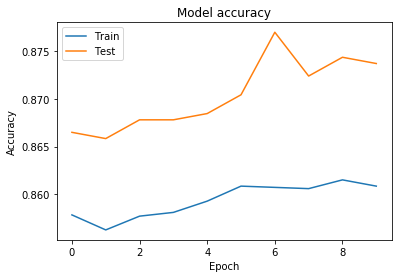

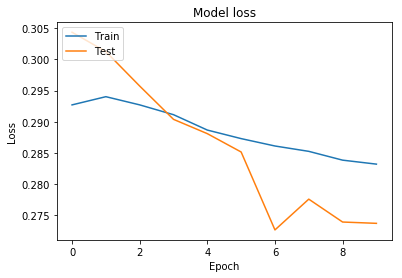

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
inference_generator= power_data_generator(batch_size=1,gen_type='inference')  #Generator for getting only input data

In [0]:
test_input = next(inference_generator)  #Get next batch of input data from data set
model.predict_on_batch(test_input)   #Probability predictions for giving input

<tf.Tensor: id=2311440, shape=(2, 8), dtype=float32, numpy=
array([[9.99965191e-01, 7.41183758e-05, 0.00000000e+00, 3.28554094e-01,
        6.92944109e-01, 0.00000000e+00, 9.99999523e-01, 5.06639481e-07],
       [9.90789413e-01, 1.12550855e-02, 0.00000000e+00, 9.99681294e-01,
        4.30047512e-04, 0.00000000e+00, 9.99893308e-01, 1.11430883e-04]],
      dtype=float32)>